drive mount
dataset load
rezise (252 X 252 )
Augmentation
NOrmlization
training and testing split
CNN model train

# Mount the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Resizing all image into 252 X 252

In [ ]:
!pip install pillow_heif


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.6 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image
import pillow_heif  # For HEIC support

# Define paths
input_folder = "/content/drive/MyDrive/DL_8/0_5"  # Source folder
output_folder = "/content/drive/MyDrive/DL_8/updated_0_5"  # Output folder

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Resize all images
for filename in os.listdir(input_folder):
    img_path = os.path.join(input_folder, filename)

    try:
        # Convert HEIC to JPEG
        if filename.lower().endswith(".heic"):
            heif_image = pillow_heif.open_heif(img_path)
            img = Image.frombytes(
                heif_image.mode,
                heif_image.size,
                heif_image.data
            )
            filename = filename.replace(".heic", ".jpg")  # Change extension to .jpg
            save_format = "JPEG"
        elif filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img = Image.open(img_path)
            save_format = img.format  # Keep original format
        else:
            continue  # Skip non-image files

        # Resize image
        img_resized = img.resize((252, 252))

        # Save resized image
        output_path = os.path.join(output_folder, filename)
        img_resized.save(output_path, format=save_format)  # Ensure correct format

    except Exception as e:
        print(f"Error processing {filename}: {e}")

print("✅ All images resized to 252x252!")


✅ All images resized to 252x252!


# Performing Augmentation


In [ ]:
import os
import cv2
import numpy as np
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomBrightnessContrast, Rotate, GaussianBlur, Compose, Resize
)

# Define paths
input_folder = "/content/drive/MyDrive/DL_8/updated_0_5"
output_folder = "/content/drive/MyDrive/DL_8/dataset_0_5_updated"
os.makedirs(output_folder, exist_ok=True)

# Augmentation pipeline
augmentations = Compose([
    Resize(252, 252),  # Ensure all images are 252x252
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomBrightnessContrast(p=0.5),
    GaussianBlur(blur_limit=3, p=0.3),
])

# Augment images
count = 0
for filename in os.listdir(input_folder):
    if filename.endswith((".jpg", ".jpeg", ".png", ".HEIC")):
        img_path = os.path.join(input_folder, filename)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Generate 2 augmented versions of each image
        for i in range(10):  # Change 2 to a higher number for more variations
            augmented = augmentations(image=image)['image']
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_{i}.jpg")
            cv2.imwrite(output_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
            count += 1

print(f"Generated {count} augmented images.")
print("All Done ✅✅")

Generated 1010 augmented images.
All Done ✅✅


# Renaming all images from 1 to n

In [ ]:
import os
import shutil

def rename_and_move_files(input_folder, output_folder):
    # Ensure the destination folder exists
    os.makedirs(output_folder, exist_ok=True)

    # List and sort all files in the source directory
    files = sorted(os.listdir(input_folder))

    # Filter only files (excluding directories)
    files = [f for f in files if os.path.isfile(os.path.join(input_folder, f))]

    # Rename and move files
    for index, filename in enumerate(files, start=1):
        file_extension = os.path.splitext(filename)[1]  # Get file extension
        new_filename = f"{index}{file_extension}"  # Create new filename

        source_path = os.path.join(input_folder, filename)
        destination_path = os.path.join(output_folder, new_filename)

        shutil.copy2(source_path, destination_path)  # Copy with metadata

    print(f"Files renamed and moved successfully.")

# Example usage
input_folder = "/content/drive/MyDrive/DL_8/dataset_0_5_updated"  # Change to your source folder
output_folder = "/content/drive/MyDrive/DL_8/dataset_0_5_renamed"  # Change to your destination folder

rename_and_move_files(input_folder, output_folder)


Files renamed and moved successfully.


# Normalisation

In [ ]:
import cv2
import numpy as np
import os
import glob
from PIL import Image
import pillow_heif  # For HEIC format support

# Function to normalize images
def normalize_image(img_path, target_size=(252, 252)):
    """
    Reads an image, resizes it, and normalizes pixel values to the range [0,1].

    Args:
        img_path (str): Path to the image.
        target_size (tuple): Desired image size (width, height).

    Returns:
        np.array: Normalized image array.
    """

    # Check if file is HEIC format
    if img_path.lower().endswith('.heic'):
        heif_file = pillow_heif.open_heif(img_path)  # Load HEIC image
        img = Image.frombytes(
            heif_file.mode, heif_file.size, heif_file.data[0]
        )  # Convert HEIC to PIL Image
        img = np.array(img)  # Convert to NumPy array
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert PIL Image to OpenCV BGR
    else:
        # Read image using OpenCV (faster)
        img = cv2.imread(img_path)

        # Convert BGR (OpenCV default) to RGB (standard format)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image to target size (252x252) with INTER_AREA (better for downscaling)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    # Normalize pixel values from [0,255] → [0,1]
    img = img.astype(np.float32) / 255.0

    return img


# Function to process all images in a directory
def process_images(input_folder, output_folder):
    """
    Processes all images in the input folder, normalizes them, and saves the results.

    Args:
        input_folder (str): Folder containing raw images.
        output_folder (str): Folder to save normalized images.
    """

    # Create output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get all image files (JPEG, JPG, PNG, HEIC) - Case insensitive
    image_files = []
    for ext in ["*.png", "*.jpg", "*.jpeg", "*.heic"]:
        image_files.extend(glob.glob(os.path.join(input_folder, ext)))

    # Process each image
    for img_path in image_files:
        try:
            # Normalize the image
            normalized_img = normalize_image(img_path)

            # Convert back to 8-bit (0-255) for saving
            normalized_img_255 = (normalized_img * 255).astype(np.uint8)

            # Get filename and save the processed image
            filename = os.path.basename(img_path)
            save_path = os.path.join(output_folder, filename)

            cv2.imwrite(save_path, cv2.cvtColor(normalized_img_255, cv2.COLOR_RGB2BGR))  # Save in OpenCV format

            print(f"✅ Processed: {filename}")
        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")


# Example Usage
input_folder = "/content/drive/MyDrive/DL_8/dataset_0_5_renamed"  # Folder containing original images
output_folder = "/content/drive/MyDrive/DL_8/datasets/Mango"  # Folder to save normalized images

process_images(input_folder, output_folder)


✅ Processed: 1.jpg
✅ Processed: 2.jpg
✅ Processed: 3.jpg
✅ Processed: 4.jpg
✅ Processed: 5.jpg
✅ Processed: 6.jpg
✅ Processed: 7.jpg
✅ Processed: 8.jpg
✅ Processed: 9.jpg
✅ Processed: 10.jpg
✅ Processed: 11.jpg
✅ Processed: 12.jpg
✅ Processed: 13.jpg
✅ Processed: 14.jpg
✅ Processed: 15.jpg
✅ Processed: 16.jpg
✅ Processed: 17.jpg
✅ Processed: 18.jpg
✅ Processed: 19.jpg
✅ Processed: 20.jpg
✅ Processed: 21.jpg
✅ Processed: 22.jpg
✅ Processed: 23.jpg
✅ Processed: 24.jpg
✅ Processed: 25.jpg
✅ Processed: 26.jpg
✅ Processed: 27.jpg
✅ Processed: 28.jpg
✅ Processed: 29.jpg
✅ Processed: 30.jpg
✅ Processed: 31.jpg
✅ Processed: 32.jpg
✅ Processed: 33.jpg
✅ Processed: 34.jpg
✅ Processed: 35.jpg
✅ Processed: 36.jpg
✅ Processed: 37.jpg
✅ Processed: 38.jpg
✅ Processed: 39.jpg
✅ Processed: 40.jpg
✅ Processed: 41.jpg
✅ Processed: 42.jpg
✅ Processed: 43.jpg
✅ Processed: 44.jpg
✅ Processed: 45.jpg
✅ Processed: 46.jpg
✅ Processed: 47.jpg
✅ Processed: 48.jpg
✅ Processed: 49.jpg
✅ Processed: 50.jpg
✅ Process

# Training and Testing

Found 5060 files belonging to 5 classes.
Using 4048 files for training.
Found 5060 files belonging to 5 classes.
Using 1012 files for validation.
Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 34s 224ms/step - accuracy: 0.7081 - loss: 1.0426 - val_accuracy: 0.7895 - val_loss: 0.5655
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 34s 172ms/step - accuracy: 0.8727 - loss: 0.3680 - val_accuracy: 0.9160 - val_loss: 0.2207
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - accuracy: 0.9163 - loss: 0.2355 - val_accuracy: 0.9358 - val_loss: 0.1880
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9224 - loss: 0.2033 - val_accuracy: 0.9516 - val_loss: 0.1626
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - accuracy: 0.9465 - loss: 0.1598 - val_accuracy: 0.9575 - val_loss: 0.1407
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.9534 - loss: 0.1386 - val_accuracy: 0.8557 - val_loss: 0.4306
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 194ms/step - accuracy: 0

Test Accuracy: 0.99
Test Loss: 0.05


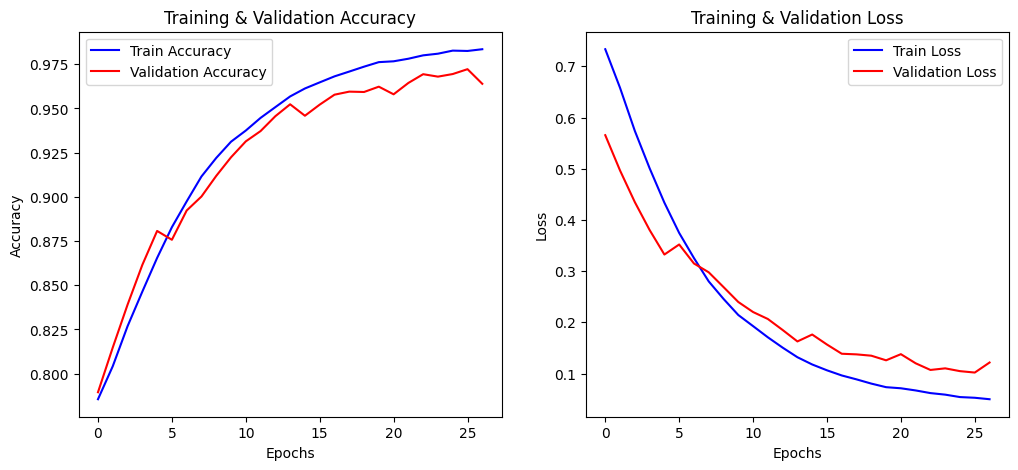

In [14]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

# Define Paths & Parameters
data_dir = "/content/drive/MyDrive/DL_8/datasets/"
img_size = (252, 252)
batch_size = 32
num_classes = 5

# Load dataset and split (80% Train, 20% Validation)
train_dataset = image_dataset_from_directory(
    data_dir, shuffle=True, image_size=img_size, batch_size=batch_size, validation_split=0.2, subset="training", seed=42
)
val_dataset = image_dataset_from_directory(
    data_dir, shuffle=True, image_size=img_size, batch_size=batch_size, validation_split=0.2, subset="validation", seed=42
)

# Data Augmentation Layer
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2)
])

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Build CNN Model with Batch Normalization
model = keras.Sequential([
    data_augmentation,

    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(252, 252, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile Model with Low Learning Rate
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping to Prevent Overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30, callbacks=[early_stopping])

# Evaluate Model
test_loss, test_acc = model.evaluate(val_dataset)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Save the model
model.save("plant_identifier.h5")

# Function to Smooth Curves
def smooth_curve(points, factor=0.8):
    smoothed = []
    for p in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + p * (1 - factor))
        else:
            smoothed.append(p)
    return smoothed

# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

# Accuracy plot with smoothing
plt.subplot(1, 2, 1)
plt.plot(smooth_curve(history.history['accuracy']), label='Train Accuracy', color='blue')
plt.plot(smooth_curve(history.history['val_accuracy']), label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss plot with smoothing
plt.subplot(1, 2, 2)
plt.plot(smooth_curve(history.history['loss']), label='Train Loss', color='blue')
plt.plot(smooth_curve(history.history['val_loss']), label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()


Found 5060 files belonging to 5 classes.
Using 4048 files for training.
Found 5060 files belonging to 5 classes.
Using 1012 files for validation.
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.6759 - loss: 1.1921 - val_accuracy: 0.7480 - val_loss: 0.6791
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - accuracy: 0.8793 - loss: 0.3474 - val_accuracy: 0.8498 - val_loss: 0.4132
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.9075 - loss: 0.2837 - val_accuracy: 0.8528 - val_loss: 0.3736
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 198ms/step - accuracy: 0.9344 - loss: 0.1863 - val_accuracy: 0.8360 - val_loss: 0.4386
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.9509 - loss: 0.1611 - val_accuracy: 0.9595 - val_loss: 0.1182
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - accuracy: 0.9492 - loss: 0.1398 - val_accuracy: 0.9358 - val_loss: 0.1784
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.9608 - loss: 0.1153 - val_accuracy: 0.9457 - val_loss: 0.1475
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 39s 179ms/step - accuracy: 0.9561 - loss: 0.1229 - val

Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 177ms/step - accuracy: 0.6472 - loss: 1.1916 - val_accuracy: 0.7411 - val_loss: 0.6814
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.8509 - loss: 0.4567 - val_accuracy: 0.8992 - val_loss: 0.2885
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 198ms/step - accuracy: 0.9022 - loss: 0.2970 - val_accuracy: 0.9289 - val_loss: 0.2060
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.9190 - loss: 0.2295 - val_accuracy: 0.8617 - val_loss: 0.3827
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 196ms/step - accuracy: 0.9333 - loss: 0.1941 - val_accuracy: 0.9545 - val_loss: 0.1684
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.9528 - loss: 0.1518 - val_accuracy: 0.9555 - val_loss: 0.1547
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - accuracy: 0.9522 - loss: 0.1372 - val_accuracy: 0.9516 - val_loss: 0.1538
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step - accuracy: 0.9673 - loss: 0

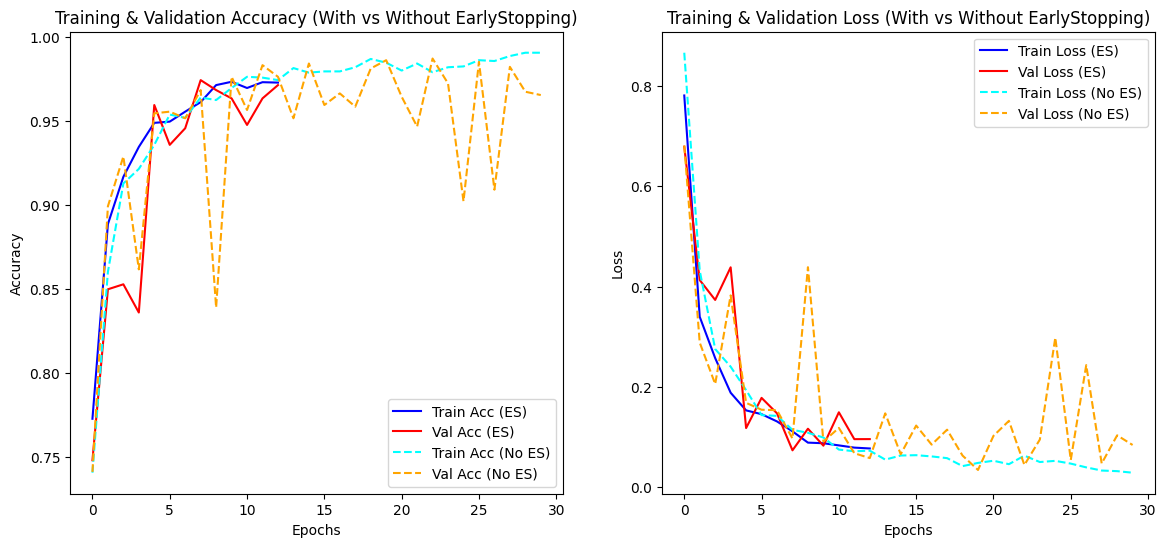

In [12]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np

# Define Paths & Parameters
data_dir = "/content/drive/MyDrive/DL_8/datasets/"
img_size = (252, 252)
batch_size = 32
num_classes = 5

# Load dataset and split (80% Train, 20% Validation)
train_dataset = image_dataset_from_directory(
    data_dir, shuffle=True, image_size=img_size, batch_size=batch_size, validation_split=0.2, subset="training", seed=42
)
val_dataset = image_dataset_from_directory(
    data_dir, shuffle=True, image_size=img_size, batch_size=batch_size, validation_split=0.2, subset="validation", seed=42
)

# Data Augmentation Layer
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2)
])

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Build CNN Model with Batch Normalization
model1 = keras.Sequential([
    data_augmentation,

    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(252, 252, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile Model with Low Learning Rate
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Train Model WITH EarlyStopping ---
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_with_es = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping],
    verbose=1
)

# Save EarlyStopping model
model1.save("plant_identifier_with_es.h5")


# --- Rebuild Model (fresh weights) for training WITHOUT EarlyStopping ---
model2 = keras.Sequential([
    data_augmentation,

    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(252, 252, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train FULL 30 epochs without EarlyStopping
history_no_es = model2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose=1
)

# Save No-EarlyStopping model
model2.save("plant_identifier_no_es.h5")


# --- Compare Plots ---
plt.figure(figsize=(14,6))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_with_es.history['accuracy'], label='Train Acc (ES)', color='blue')
plt.plot(history_with_es.history['val_accuracy'], label='Val Acc (ES)', color='red')
plt.plot(history_no_es.history['accuracy'], '--', label='Train Acc (No ES)', color='cyan')
plt.plot(history_no_es.history['val_accuracy'], '--', label='Val Acc (No ES)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy (With vs Without EarlyStopping)')

# Loss
plt.subplot(1,2,2)
plt.plot(history_with_es.history['loss'], label='Train Loss (ES)', color='blue')
plt.plot(history_with_es.history['val_loss'], label='Val Loss (ES)', color='red')
plt.plot(history_no_es.history['loss'], '--', label='Train Loss (No ES)', color='cyan')
plt.plot(history_no_es.history['val_loss'], '--', label='Val Loss (No ES)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss (With vs Without EarlyStopping)')

plt.show()


Saving 1007.jpg to 1007.jpg
Selected file: 1007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted species: Neem
Confidence: 97.32 %


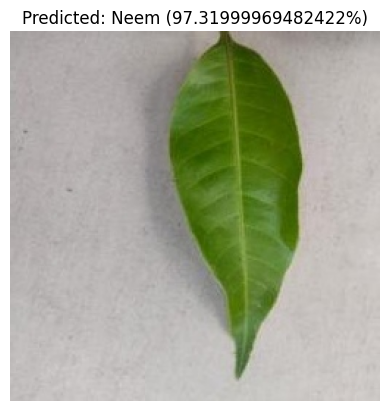

In [11]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Open file picker and choose an image
uploaded = files.upload()

# Get the uploaded file path
img_path = list(uploaded.keys())[0]
print("Selected file:", img_path)

# Load and preprocess uploaded image
img = image.load_img(img_path, target_size=(252, 252))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = np.max(predictions[0])

print("Predicted species:", class_names[predicted_class])
print("Confidence:", round(confidence*100, 2), "%")

# Show the image with label
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {class_names[predicted_class]} ({round(confidence*100,2)}%)")
plt.show()
